# where is floating?

##
### Datapaper plots

1. field_location.png Modis moa Inset map, ant in corner, icestreams scale, square of common border, include flow route,
2. geophysics_overview.png Map of all data presented
3. historic_channel.png Historic landsat images
4. thickness_surfacecolour.png Profile depth
6. 3D view of channel
7. radarlines 
8. channel_meander.png meander
11. ApRES include stress
9. Icesat1/REMA
10. Icesat2


In [3]:
import matplotlib.pyplot as plt
import numpy as np
import glob
import os
import sys
import time
import datetime as dt
import pandas as pd
import geopandas as gpd
import scipy as sp
from scipy import signal
from tqdm.notebook import tqdm_notebook
import rasterio as rio
from shapely.geometry import Point, LineString, Polygon, MultiPoint
import fiona
from shapely.ops import nearest_points
from rasterio.windows import Window
import string
import matplotlib.gridspec as gridspec

In [4]:
from scipy.integrate import quad


In [8]:
!pwd

/Users/home/whitefar/DATA/Jupyter/RADAR/RADAR_MAP


# density profile

In [6]:
acc = 0.11
T = -27.3
rho_0 = 0.300
z = np.arange(0,700,0.01)

# (1) parameters
T = (273-np.abs(T)) # Temperature (Kelvin)

# (2) constants
# velocities c (metre per second) and relative permittivity E
# ice density (Mg/m^3)
rho_i = 0.917
# critical density (stage 1-2 densification transition)
rho_c = 0.55
# water density
rho_w = 1  

# (3) density  vs. depth profile (look-up table to 5000 metres)
# from Herron-Langway model (1980)
# rho vs. z, where rho is in Mg per cubic metres

R = 8.314

k0 = 11*np.exp(-10160/(R*T)) # 11*exp(-10160/(R*T))
k1 = 575*np.exp(-21400/(R*T))
alpha = np.log(rho_0/(rho_i-rho_0))
beta = np.log(rho_c/(rho_i-rho_c))  

# WATER-equiv accumulation rate (m/year)
A = acc*rho_i/rho_w  
# critical depth hc (metre)
hc = (beta-alpha)/(rho_i*k0)  

# density profile evaluation
Z=(z<hc).astype(int)*np.exp(rho_i*k0*z+alpha) + (z>=hc).astype(int)*np.exp(rho_i*k1*(z-hc)/(A**0.5)+beta)

rho=rho_i*Z/(1+Z)

np.sum(rho)/10

sea_i = np.argwhere(np.cumsum(rho)<np.sum(rho)/10)[-1][0]
crude_float_level = z[sea_i]

f_rho = sp.interpolate.interp1d(z,rho)

sum_density = quad(f_rho,0,500)[0]

In [ ]:
def float_level(thickness):
    """
    input: thickness,
    output: where sea level is in m below the surface
    """
        
    if np.isnan(thickness):
        return np.nan
    
    acc = 0.11
    T = -27.3
    rho_0 = 0.300
    z = np.arange(0,600,0.01)

    # (1) parameters
    T = (273-np.abs(T)) # Temperature (Kelvin)

    # (2) constants
    # velocities c (metre per second) and relative permittivity E
    # ice density (Mg/m^3)
    rho_i = 0.917
    # critical density (stage 1-2 densification transition)
    rho_c = 0.55
    # water density
    rho_w = 1  

    # (3) density  vs. depth profile (look-up table to 5000 metres)
    # from Herron-Langway model (1980)
    # rho vs. z, where rho is in Mg per cubic metres

    R = 8.314

    k0 = 11*np.exp(-10160/(R*T)) # 11*exp(-10160/(R*T))
    k1 = 575*np.exp(-21400/(R*T))
    alpha = np.log(rho_0/(rho_i-rho_0))
    beta = np.log(rho_c/(rho_i-rho_c))  

    # WATER-equiv accumulation rate (m/year)
    A = acc*rho_i/rho_w  
    # critical depth hc (metre)
    hc = (beta-alpha)/(rho_i*k0)  

    # density profile evaluation
    Z=(z<hc).astype(int)*np.exp(rho_i*k0*z+alpha) + (z>=hc).astype(int)*np.exp(rho_i*k1*(z-hc)/(A**0.5)+beta)

    rho=rho_i*Z/(1+Z)

    np.sum(rho)/10

    sea_i = np.argwhere(np.cumsum(rho)<np.sum(rho)/10)[-1][0]

    return z[sea_i]

In [69]:
def find_float(float_level):
    """function to minimise"""
    
    return quad(f_rho,0,float_level)[0]*9 - quad(f_rho,float_level,thickness)[0]
    

In [70]:
thickness = 700

In [72]:
sp.optimize.newton(find_float,80)

87.13706507099414

In [73]:
# Load ice base interpolated from radar results
direc = '/Users/home/whitefar/DATA/FIELD_ANT_19/POST_FIELD/RADAR_MAP/interpolatedgrid_allchan'

xv = np.load(direc + 'x_grid' +'.npy')
yv = np.load(direc + 'y_grid' +'.npy')
thickness_interpolated = np.load(direc +'ice_thickness'+'.npy')
REMA_surf = np.load('/Users/home/whitefar/DATA/FIELD_ANT_19/POST_FIELD/RADAR_MAP/highres_chan_surf.npy')

extent_l2l = np.load(direc +'extent.npy')
ice_base = np.load(direc +'_ice_base.npy')
ice_base_smooth = sp.ndimage.gaussian_filter(ice_base, sigma=30, order=0)

In [2]:
sl = 50

tic = time.process_time()

for idx, x in np.ndenumerate(thickness_interpolated[:300,:300]):
    if not np.isnan(x):
        sl = sp.optimize.newton(find_float,sl)
        sea_level_below_surf[idx] = sl
toc = time.process_time()
print(toc - tic)

NameError: name 'time' is not defined

In [82]:
thickness_interpolated.shape

(6153, 4128)

## this way was too slow

In [74]:
sea_level_below_surf = np.zeros(thickness_interpolated.shape)

In [75]:
import time

In [80]:
tic = time.process_time()
for idx, x in np.ndenumerate(thickness_interpolated[:100,:100]):
    if not np.isnan(x):
        sea_level_below_surf[idx] = float_level(x)
toc = time.process_time()
print(toc - tic)

0.02455417499999868


In [31]:
(toc - tic)/100*thickness_interpolated.shape[0]*thickness_interpolated.shape[1]/60

6.9498299408093605

In [ ]:
for idx, x in np.ndenumerate(thickness_interpolated):
    if not np.isnan(x):
        sea_level_below_surf[idx] = float_level(x)

In [ ]:
np.save('/Users/home/whitefar/DATA/FIELD_ANT_19/POST_FIELD/RADAR_MAP/sea_level_below_surf.npy',sea_level_below_surf)

In [ ]:
sea_level_from_thickness_geoid = REMA_surf + 47 - sea_level_below_surf #sea level from thickness, relative to the geoid

In [193]:
acc = 0.11
T = -27.3
rho_0 = 0.300
z = np.arange(0,600,0.01)

In [176]:
# (1) parameters
T = (273-np.abs(T)) # Temperature (Kelvin)

In [177]:
# (2) constants
# velocities c (metre per second) and relative permittivity E
# ice density (Mg/m^3)
rho_i = 0.917
# critical density (stage 1-2 densification transition)
rho_c = 0.55
# water density
rho_w = 1  

In [178]:
# (3) density  vs. depth profile (look-up table to 5000 metres)
# from Herron-Langway model (1980)
# rho vs. z, where rho is in Mg per cubic metres
 
R = 8.314

In [179]:
k0 = 11*np.exp(-10160/(R*T)) # 11*exp(-10160/(R*T))
k1 = 575*np.exp(-21400/(R*T))
alpha = np.log(rho_0/(rho_i-rho_0))
beta = np.log(rho_c/(rho_i-rho_c))  

In [180]:
# WATER-equiv accumulation rate (m/year)
A = acc*rho_i/rho_w  
# critical depth hc (metre)
hc = (beta-alpha)/(rho_i*k0)  

In [181]:
# density profile evaluation
Z=(z<hc).astype(int)*np.exp(rho_i*k0*z+alpha) + (z>=hc).astype(int)*np.exp(rho_i*k1*(z-hc)/(A**0.5)+beta)

In [182]:
rho=rho_i*Z/(1+Z)

In [183]:
np.sum(rho)/10

5322.19806050217

In [184]:
sea_i = np.argwhere(np.cumsum(rho)<np.sum(rho)/10)[-1][0]

In [185]:
z[sea_i]

76.82000000000001

In [186]:
sea_i

7682

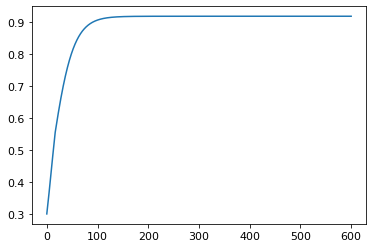

In [187]:
plt.plot(z,rho)

In [188]:
np.sum(rho[:sea_i])

5321.177867759497

In [189]:
np.sum(rho[sea_i:])

47900.8027372622

In [191]:
5321*9

47889

In [2]:
xmin, xmax, ymin, ymax = -382700, -374781.9, -734075.1, -721770.2

In [5]:
# im_REMAdiff[np.abs(im_REMAdiff)>50]=np.nan

In [13]:
# Load ice base interpolated from radar results
direc = '/Users/home/whitefar/DATA/FIELD_ANT_19/POST_FIELD/RADAR_MAP/interpolatedgrid_allchan'

xv = np.load(direc + 'x_grid' +'.npy')
yv = np.load(direc + 'y_grid' +'.npy')
thickness_interpolated = np.load(direc +'ice_thickness'+'.npy')
REMA_surf = np.load('/Users/home/whitefar/DATA/FIELD_ANT_19/POST_FIELD/RADAR_MAP/highres_chan_surf.npy')
extent_l2l = np.load(direc +'extent.npy')
ice_base = np.load(direc +'_ice_base.npy')
ice_base_smooth = sp.ndimage.gaussian_filter(ice_base, sigma=30, order=0)

In [14]:
gpr = gpd.read_file('/Volumes/arc_04/FIELD_DATA/K8621920/RES/PROCESSED_LINES/picked_bed.shp')
cross_channel_lines = ['line7p75','line7p5','line7p25','line7', 'line6','line5','lineAPREScross','line4','line3','line2','line1','line0']

In [15]:
gpr = gpr[gpr.camp=='KIS2'].copy()

In [16]:
#smooth REMA dem for contours
im_REMA_c_smoo = sp.ndimage.gaussian_filter(im_REMA_c, sigma=20, order=0)
del im_REMA_d,im_REMA_c

NameError: name 'im_REMA_c' is not defined

In [ ]:
# # get icesat2 diff lines
# import sys
# sys.path.append('/Users/home/whitefar/DATA/code/REMOTE_SENSING/ICESAT/')
# from cross_channel import icesat_dataset
# ds = icesat_dataset("/Volumes/arc_02/REMOTE_SENSING/ICESAT2/ATLAS/ATLXI/ds_subkamb_20201111.nc")
# ds.getdata_dhdt(cycle_number_from=3,cycle_number_till=8)
# ds.dadh.query(f'x>{xmin} & x<{xmax} & y<{ymax} & y>{ymin}',inplace=True)

In [36]:
REMA_surf.shape

(6153, 4128)

In [20]:
ice_base.shape

(6153, 4128)

(6153,
 4128,
 6153,
 4128,
 6153,
 4128,
 6153,
 4128,
 6153,
 4128,
 6153,
 4128,
 6153,
 4128,
 6153,
 4128,
 6153,
 4128)

In [46]:
isfloat = ice_base - REMA_surf*9

In [60]:
isfloat.shape

(6153, 4128)

In [62]:
np.histogram(isfloat[~np.isnan(isfloat)])

(array([12942447,        0,        0,        0,        0,        0,
               0,        0,        0,    25236]),
 array([-1396.94356539,  6666.62359178, 14730.19074895, 22793.75790612,
        30857.32506329, 38920.89222046, 46984.45937763, 55048.0265348 ,
        63111.59369197, 71175.16084915, 79238.72800632]))

# plot it

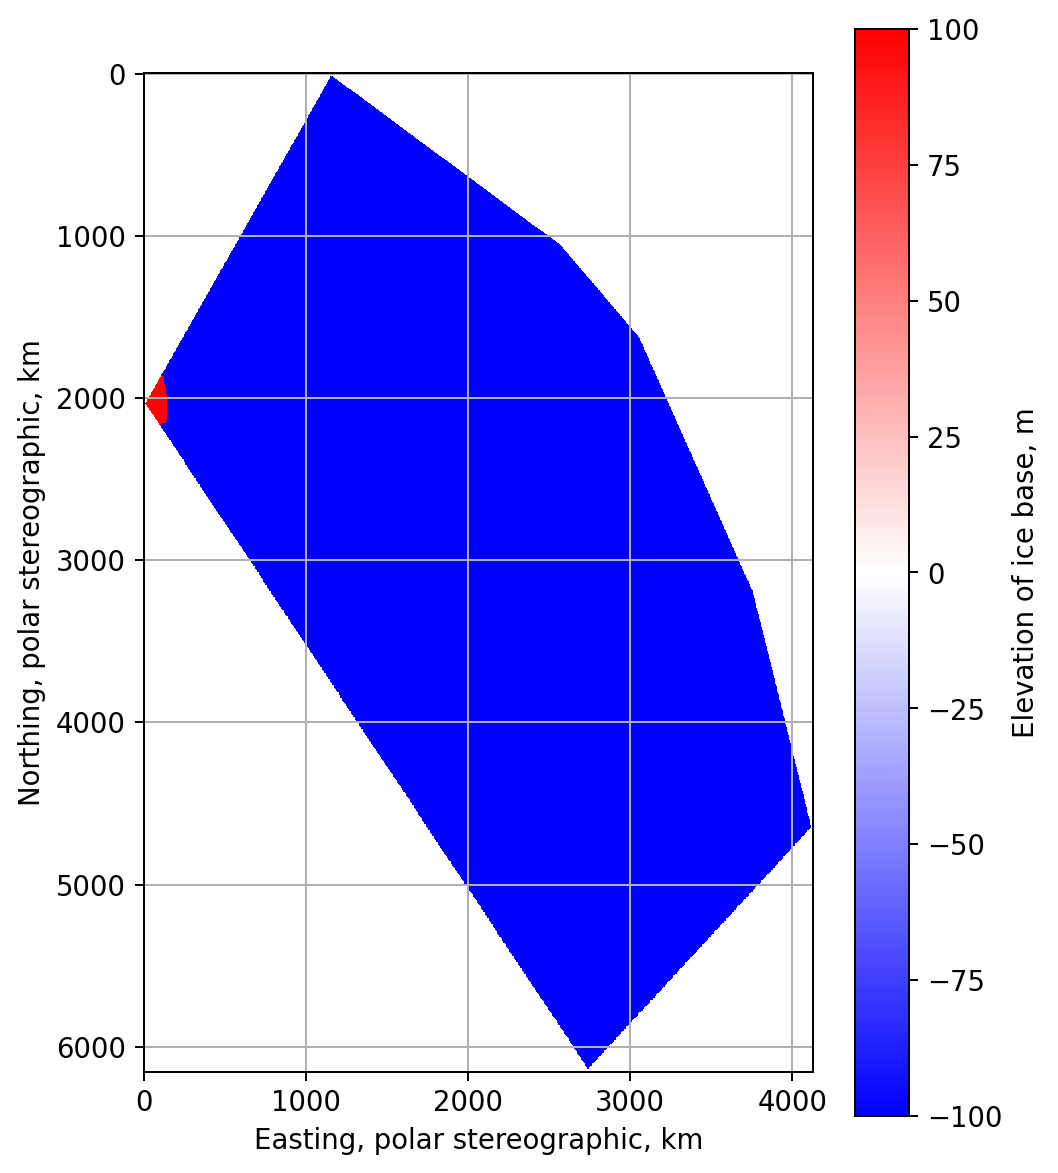

In [58]:
plt.figure( dpi=180,figsize=(6,8))

plt.rcParams.update({'font.size': 11})


# #C base with surface contours
# samp = 50
# CS =  plt.contour(xv_REMA[::samp]/1000,yv_REMA[::samp]/1000,im_REMA_c_smoo[::samp],
#                       30,vmin=15,vmax=90, 
# #                   cmap='BrBG',
#                   colors='black',
#                   alpha=0.5,linewidths=0.7)
# plt.clabel(CS,CS.levels[1::4], inline=1,  fmt='#i')

extents = 10

plt.imshow(isfloat,
           #extent=np.array(extent_l2l)/1000,
           cmap='bwr',
           vmin=-extents,vmax=extents
          )
cb3 = plt.colorbar()
cb3.set_label('Elevation of ice base, m')
# cb3.set_ticks(np.round(np.linspace(-350,-700,5)/5)*5)

# plt.plot(gpr.x/1000,gpr.y/1000,'r.',label='radar profiles',markersize=0.05)



# plt.xlim([xmin,xmax])
# plt.ylim([ymin,ymax])
# plt.xticks(xticks)
# plt.yticks(yticks)
plt.xlabel('Easting, polar stereographic, km')
plt.ylabel('Northing, polar stereographic, km')

# plt.text( -378.6,-722.5, 'IB',size=10)

# plt.text( -376.7,-722.5, 'IB',size=10)
plt.grid()

# plt.savefig('/Users/home/whitefar/ASSIGNMENTS-PUBLICATIONS-TALKS/channel_data_writeup/PLOTS/ice_base_solo.png')

##############################

plt.show()
#

In [42]:
'#.2f' # (1.323)

'1.32'

In [22]:
# https://stackoverflow.com/questions/51446526/plt-subplot-adjust-not-working-correctly

# contour only

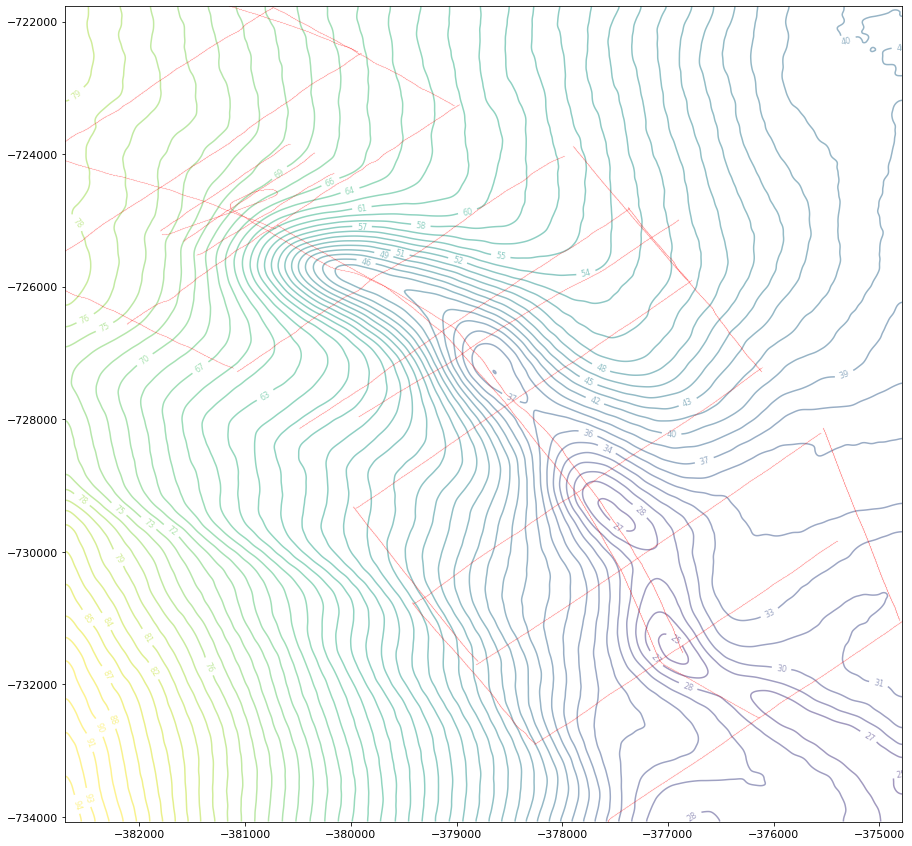

In [26]:
plt.figure(figsize=(15,15))
# fig.subplots_adjust(hspace=0.2, wspace=-0.3)

samp = 10

CS =  plt.contour(xv_REMA[::samp],yv_REMA[::samp],im_REMA_c_smoo[::samp],
                      50,vmin=15,vmax=90, alpha=0.5)
plt.clabel(CS, inline=1, fontsize=8, fmt='#i')
plt.plot(gpr.x,gpr.y,'r.',label='radar profiles',markersize=0.05)


# plt.imshow(im_REMA,extent=extent_REMA,vmin=15,vmax=90, cmap='BrBG')
# plt.grid()
plt.xlim([xmin*1000,xmax*1000])
plt.ylim([ymin*1000,ymax*1000])
# plt.tick_params(bottom=False, labelbottom=False, left=False, labelleft=False)



# cb1 = fig.colorbar(a1,ax=plt)
# cb1.label('elevation,')
# cb1.ticks(np.round(np.linspace(15,90,5)/5)*5)



plt.show()

AttributeError: 'AxesSubplot' object has no attribute 'flat'

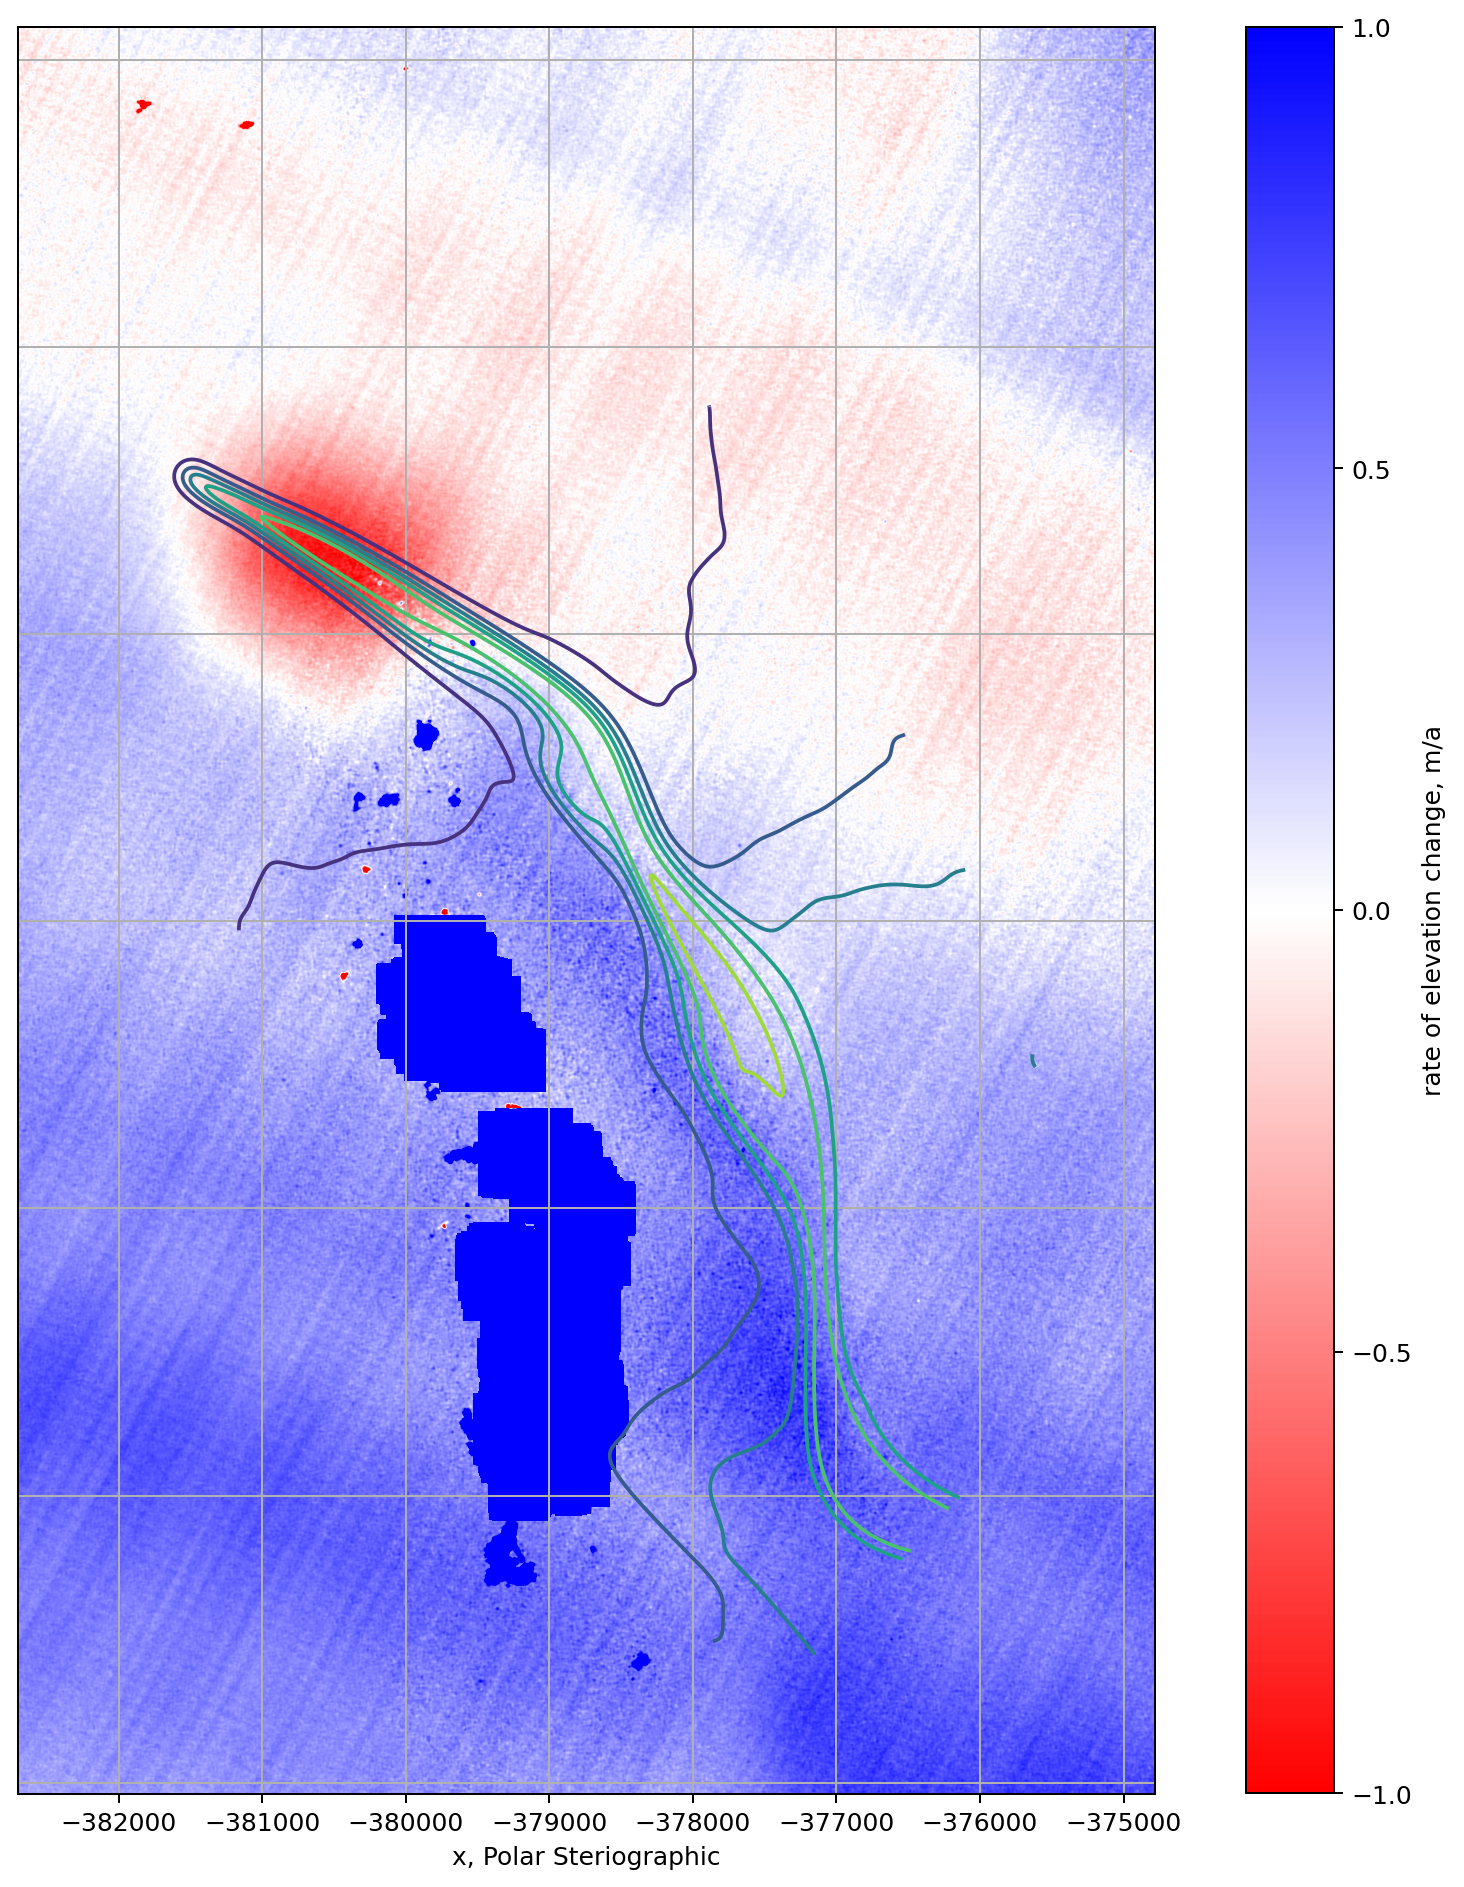

In [14]:
fig, ax = plt.subplots(1,1, dpi=180,figsize=(13,13))
# fig.subplots_adjust(hspace=0.2, wspace=-0.3)

# #

# #D rate of change of surf
CS4 =  ax.contour(xv[:,500:],yv[:,500:],ice_base_smooth[:,500:],np.arange(-700,-300,50))
# ax.clabel(CS4, inline=1, fontsize=8, fmt='#i')
ax.tick_params(left=False, labelleft=False)

im4 = ax.imshow(-im_REMAdiff,extent=extent_REMAdiff, vmin=-1,vmax=1,cmap='bwr_r')
# ax.scatter(ds.dadh.x,ds.dadh.y,c=ds.dadh.dhdt,cmap='bwr_r',vmin=-0.8, vmax=1)
ax.grid()
ax.xlim([xmin,xmax])
ax.ylim([ymin,ymax])


cb4 = fig.colorbar(im4,ax=ax)
cb4.label('rate of elevation change, m/a')
cb4.ticks(np.linspace(-1,1,5))
ax.xlabel('x, Polar Steriographic')


#write A B C D from a loop
axs = ax.flat
for n, a in enumerate(axs):
    a.text(-0.1, 1.05, string.ascii_uppercase[n], transform=a.transAxes, 
            size=20, weight='bold')

# plt.savefig('/Users/home/whitefar/ASSIGNMENTS-PUBLICATIONS-TALKS/channel_data_writeup/PLOTS/4square_channel.png')
# 
##############################

plt.show()
#

In [ ]:
# calculate surface gradient

In [29]:
dist = 1470
height = 25.5
angle = np.arctan(height/dist)

In [30]:
np.degrees(angle)

0.9938067030994084

In [33]:
(height/dist)*100

1.7346938775510203